In [7]:
#Prepared by:
#H M AHSAN HABIB KUSHAL
#AMARTYA CHOWDHURY

In [4]:
#Imports
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')


In [14]:
#lOAD DATA

train_df = pd.read_csv("C:/Users/H. M. Ahsan Habib/BAIC_2025_NITER_SOYUZ/train.csv")
test_df = pd.read_csv("C:/Users/H. M. Ahsan Habib/BAIC_2025_NITER_SOYUZ/test.csv")

train_df.head()


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,859.0,Placebo,17841.0,F,N,Y,N,N,2.1,396.0,3.70,74.0,2148.0,136.74,144.0,298.0,11.0,4.0,D
1,1,1141.0,Placebo,18102.0,F,N,Y,Y,S,2.1,187.0,3.48,4.0,918.0,120.90,90.0,213.0,12.4,2.0,D
2,2,853.0,D-penicillamine,16728.0,F,N,Y,Y,N,5.7,482.0,3.67,161.0,11552.0,136.74,165.0,102.0,11.5,4.0,D
3,3,1785.0,D-penicillamine,19358.0,F,N,Y,N,N,2.1,350.0,3.36,74.0,661.0,272.80,231.0,166.0,11.4,4.0,D
4,4,1418.0,Placebo,22306.0,F,N,Y,Y,S,2.0,426.0,3.74,86.0,13862.4,136.00,114.0,339.0,11.0,4.0,D


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8457 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8464 non-null   object 
 6   Hepatomegaly   8453 non-null   object 
 7   Spiders        8449 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6623 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8338 non-null   float64
 13  Alk_Phos       8450 non-null   float64
 14  SGOT           8446 non-null   float64
 15  Tryglicerides  6574 non-null   float64
 16  Platelets      14462 non-null  float64
 17  Prothrombin    14981 non-null  float64
 18  Stage 

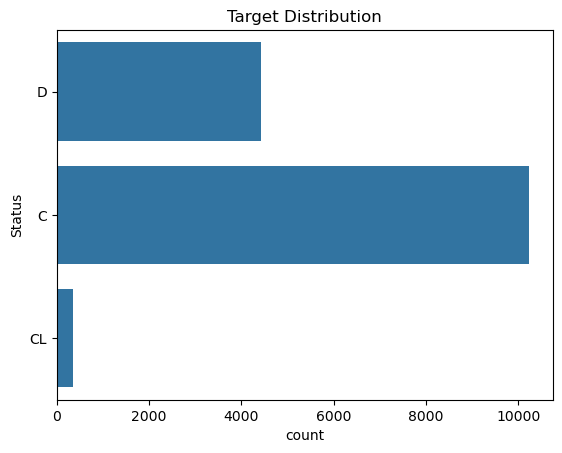

In [16]:
#EXPLORATORY DATA ANALYSIS (EDA)
train_df.info()
train_df.describe()
train_df.isnull().sum()
sns.countplot(train_df["Status"])
plt.title("Target Distribution")
plt.show()


In [17]:
#MERGE AND PREPROCESSING STEPS
test_ids = test_df["id"]

train_df["is_test"] = 0
test_df["is_test"] = 1
y = train_df["Status"]

data = pd.concat([train_df.drop(columns=["Status"]), test_df], ignore_index=True)



In [18]:
#MISSING VALUES HANDLING
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    data[col].fillna(data[col].median(), inplace=True)

cat_cols = data.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    data[col].fillna("Missing", inplace=True)


In [19]:
#FEATURE ENGINEERING
skewed_cols = ['Bilirubin', 'Cholesterol', 'Alk_Phos',
               'SGOT', 'Tryglicerides', 'Prothrombin', 'Copper']

for col in skewed_cols:
    if col in data.columns:
        data[f"Log_{col}"] = np.log1p(data[col])

data["Bili_Alb_Ratio"] = data["Bilirubin"] / (data["Albumin"] + 1e-6)
data["Prothr_Plat_Ratio"] = data["Prothrombin"] / (data["Platelets"] + 1e-6)
data["Diagnosis_Date"] = data["Age"] - data["N_Days"]


In [20]:
#LABEL ENCODING AND ONE-HOT ENCODING
le = LabelEncoder()
y_encoded = le.fit_transform(y)

data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

if "id" in data:
    data = data.drop(columns=["id"])


In [21]:
#SPLIT TRAIN-TEST
X_train = data[data["is_test"] == 0].drop(columns=["is_test"]).values
X_test  = data[data["is_test"] == 1].drop(columns=["is_test"]).values


In [22]:
#MODEL DEFINITION
xgb_params = {
    'n_estimators': 6800,
    'learning_rate': 0.002,
    'max_depth': 5,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'random_state': 41,
    'n_jobs': -1,
    'tree_method': 'hist'
}
xgb_model = XGBClassifier(**xgb_params)

lgbm_params = {
    'n_estimators': 5200,
    'learning_rate': 0.009,
    'max_depth': 8,
    'num_leaves': 63,
    'subsample': 0.9,
    'colsample_bytree': 0.000009,
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'random_state': 41,
    'n_jobs': -1
}
lgbm_model = LGBMClassifier(**lgbm_params)

cat_params = {
    'iterations': 3700,
    'learning_rate': 0.030,
    'depth': 5,
    'loss_function': 'MultiClass',
    'verbose': 0,
    'random_seed': 41
}
cat_model = CatBoostClassifier(**cat_params)


In [23]:
#VOTING ENSEMBLE
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('cat', cat_model)
    ],
    voting="soft",
    weights=[1.9, 4.6, 2.5]
)


In [ ]:
#CROSS VALIDATION TRAINING
kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=41)

oof_preds = np.zeros((X_train.shape[0], 3))
test_preds = np.zeros((X_test.shape[0], 3))

for fold, (tr, val) in enumerate(kf.split(X_train, y_encoded)):
    X_tr, X_val = X_train[tr], X_train[val]
    y_tr, y_val = y_encoded[tr], y_encoded[val]

    ensemble.fit(X_tr, y_tr)

    val_pred = ensemble.predict_proba(X_val)
    oof_preds[val] = val_pred
    test_preds += ensemble.predict_proba(X_test) / 8

    print(f"Fold {fold+1} LogLoss:", log_loss(y_val, val_pred))

print("Overall CV LogLoss:", log_loss(y_encoded, oof_preds))


In [ ]:
#CONFUSION MATRIX
cm = confusion_matrix(y_encoded, oof_preds.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#SUBMISSION
submission_df = pd.DataFrame(test_preds, columns=[f'Status_{cls}' for cls in le.classes_])
submission_df.insert(0, "id", test_ids)

# Clip + Normalize
EPS = 1e-15
cols = ['Status_C', 'Status_CL', 'Status_D']
submission_df[cols] = submission_df[cols].clip(EPS, 1-EPS)
submission_df[cols] = submission_df[cols].div(submission_df[cols].sum(axis=1), axis=0)

submission_df.to_csv("submission.csv", index=False)
submission_df.head()
